# NOTE: These notes are currently incomplete and will be updated before the workshop

# Afternoon: Introduction to Spatial Analysis
Now that we've learned the basics of time series autocorrelation, we're ready to extend the concept to spatial dimensions. We'll see that spatial dimensions are a direct generalization of temporal dimension, and the concept of $lag$ carries over almost exactly. 

The first thing we do is remove the previous workspace and load the required packages

In [34]:
rm(list=ls())
library(nlme)                              #package to fit statistical models with autocorrelation
library(fields)                            #package for nice image plots
library(sp)                                #package for spatial data frames
library(gstat)
library(colorRamps)                        #package for custom R colors
rmat90 <- function(x) t(apply(x, 2, rev))  #function to rotate a matrix 90 degrees for plotting

## Simulate spatially correlated data
To get a sense how autocorrelation creates spatial patterns, let's try simulating data with different properties. Analogous to time series, we'll use a covariance matrix to describe the autocorrelation among variables within a statistical model. And remember again, we treat each observation as arising as a realization from a probability distribution. So when we talk about *correlations in the data* we are really taking about the correlation among these random variables that we describe statistically.  

There is an analagous autoregressive model for spatial data; however, it's a little more complicated to numerically optimize so we will use the common *exponential autocorrelation function* which closely approximates the autoregressive model, giving rise to very similar behaviour where *values closer to one another are more typically similar than values further away*. The approximation is $\alpha^{\tau} \approx e^{-r\tau}$, where $r$ is referred to as the *exponential decay parameter*. The exponential spatial covariance matrix takes the form

$$ \mathbf{\Sigma}_{exp} = \sigma^2 \begin{bmatrix}
   	  	    1 & e^{-rd_{1,2}} &          e^{-rd_{1,3}} &  \dots  & e^{-rd_{1,n}} \\
e^{-rd_{2,1}} &             1 &          e^{-rd_{2,3}} &  \ddots & e^{-rd_{2,n}} \\ 
e^{-rd_{3,1}} & e^{-rd_{3,2}} &                      1 & \ddots  & \vdots \\
       \vdots &        \ddots &                 \ddots &  \ddots & e^{-rd_{n-1,n}} \\
e^{-rd_{n,1}} & e^{-rd_{n,2}} & \dots & e^{rd_{n,n-1}} &       1 \end{bmatrix}  $$

Below we're going to simulate some data with exponential spatial correlation to get a sense of how this model generates spatial patterns. We'll consider a simulated 30x30 grid of observations. The key function below is the ``dist()`` command which computes the pairwise distances for all synthetic points. The $\mathbf{C}$ matrix defines the correlation matrix and $\mathbf{S}$ the resulting covariance matrix. Matrix $\mathbf{G}$ is the reflection of covariance which is known as the variogram. We will use this form of the covariance for spatial analysis.  

In [2]:
M  <- expand.grid(1:30, 1:30)  #Two column matrix with all pair-wise coordinates
n  <- nrow(M)                  #Number of pairs
D  <- as.matrix(dist(M))       #Compute pair-wise distances
r  <- 0.1                      #Decorrelation parameter for autocorrelation function
s  <- 10                       #standard deviation
C  <- exp(-r*D)                #Correlation matrix
S  <- s^2*C                    #Construct covariance matrix 
G  <- s^2*(1 - exp(-r*D))      #Analogous variogram matrix

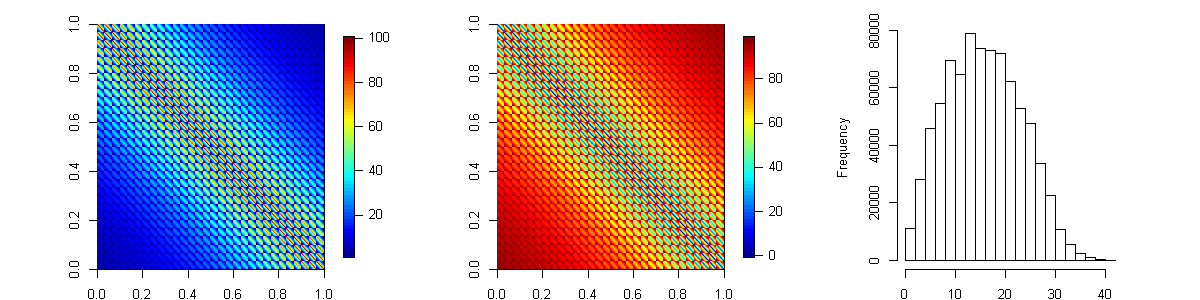

In [3]:
options(repr.plot.width=10, repr.plot.height=2.5)
par(mfrow=c(1,3))
image.plot(rmat90(S))       #visualize the covariance matrix
image.plot(rmat90(G))       #visualize the variogram matrix
hist(c(D))                  #make a histogram of the pair-wise distances

To see what's going on, consider the $iid$ vector $x_0$ with $\sigma^2 = 1$. Recall the covariance matrix for this vector is $\mathbf{\Sigma} = \sigma^2 \mathbf{I} = \mathbf{I}$. The correlated vector, on the other hand, $x = Lx_0$ has covariance $S$. 

$$ \mathrm{E}(xx^T) = \mathrm{E}((Lx_0)(Lx_0)^T) = \mathrm{E}(Lx_0x_0^TL^T) = L\mathrm{E}(x_0x_0^T)L^T$$

Now we know that $\mathrm{E}(x_0x_0^T) = I$ 

$$ L\mathrm{E}(x_0x_0^T)L^T = LIL^T = LL^T = S $$

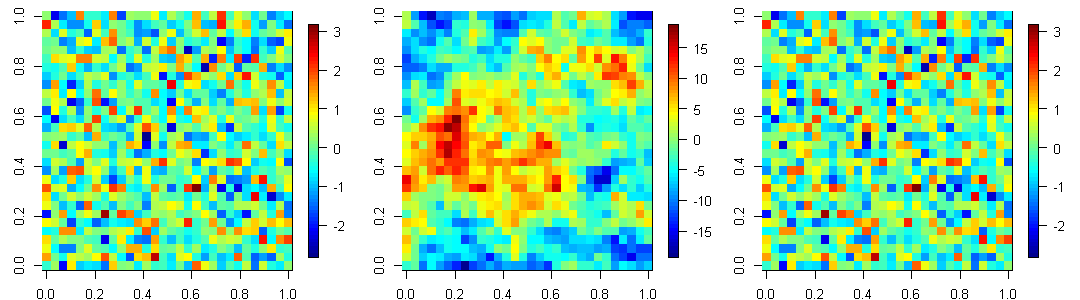

In [4]:
L  <- chol(S)                    #Cholesky factorization of the covariance matrix
Li <- solve(L)                   #Inverse of the triangular matrix for back-transform
x0  <- matrix(rnorm(n), ncol=n)  #iid random data
x   <- x0%*%L                    #transform the random data by the factored covariance matrix to generate spatial correlation
x00 <- x%*%Li                    #transform back to random data by multiplying by the inverse of the factored covariance matrix

options(repr.plot.width=9, repr.plot.height=2.5)
par(mfrow=c(1,3),mar=c(5,2,2,2))
image.plot(as.matrix(xtabs(t(x0)  ~ M[,1] + M[,2])))   #use xtabs() to fill in matrix elements with dimensions M[,1] and M[,2] 
image.plot(as.matrix(xtabs(t(x)   ~ M[,1] + M[,2])))
image.plot(as.matrix(xtabs(t(x00) ~ M[,1] + M[,2])))

## Spatial Interpolation
The term *interpolation* refers to 

First we will plot the data

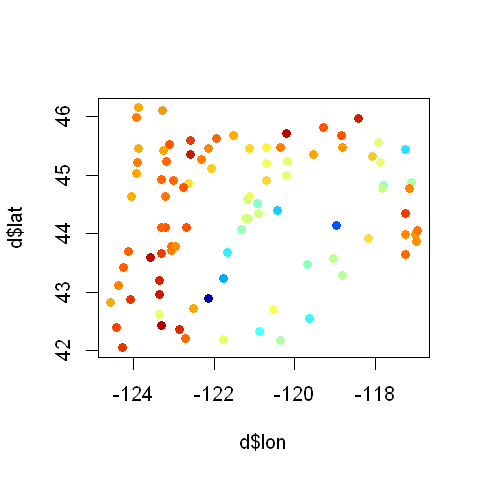

In [5]:
#d <- read.csv('../Data/oregon_temp_precip.csv',header=TRUE,stringsAsFactors=FALSE)  #read the data from your local repository  
d <- read.csv('D:/Dropbox/Teaching/Bayes/DSI/Environmental_Stats_with_Stan/Data/oregon_temp_precip.csv',header=TRUE)
cols <- matlab.like(100)[as.numeric(cut(d$temp_annual,breaks=100))]  #set point colors according to value of third variable
options(repr.plot.width=4, repr.plot.height=4)                       #parameters for Jupyter plot window
plot(d$lon,d$lat,col=cols,pch=19)                                    #scatterplot with point colors

We will use properties of the covariance to predict values at unobserved locations. In numerical packages we typically work with the variogram. There is a imple relation between the autocorrelation function and the variogram. The variogram can be written


A simple version is the exponential variogram.

$$ \gamma(y_i-y_j) = \gamma(d) = \gamma_0 \left( 1-e^{-rd} \right)  $$

where the distance is defined as as the length of the vector separating $y_i$ and $y_j$. In this workshop we will be using simple Euclidean distance, $ d_E = \sqrt{(x_2-x_1)^2 + (y_2-y_1)^2} $, and also distances computed from a projection of latitude and longitude onto a geometrical model of the earth. 

Interpolation is a bit trickier than it seems. Krigeing, or so-called *optimal interpolation* is statistically derived by finding the linear predictor that minimizes a theoretical variance. We write the linear predictor

$$ y* = \sum_{i,j} w_{i,j} y_{i,j}    $$

Given the function $\gamma(d)$, where $d$ is the distance between we can define Krigeing equations. 

$$ \begin{bmatrix}
	  \gamma(y_1,y_1) & \gamma(y_1,y_2) &  \dots & \gamma(y_1,y_n) & 1 \\
   	  \gamma(y_2,y_1) & \gamma(y_2,y_2) &  \dots & \gamma(y_2,y_n) & 1 \\
   	           \vdots &          \vdots & \ddots &         \vdots  & 1 \\ 
      \gamma(y_n,y_1) & \gamma(y_n,y_2) &  \dots & \gamma(y_n,y_n) & 1 \\
                    1 &               1 &  \dots &               1 & 0  \end{bmatrix}
\begin{bmatrix} w_1 \\ w_2 \\ \vdots \\ w_n \\ 1 \end{bmatrix} 
= \begin{bmatrix} \gamma(y_1,y_0) \\ \gamma(y_2,y_0) \\ \vdots \\ \gamma(y_n,y_0) \\ 1 \end{bmatrix} $$

This system can be written in the following way, as a block matrix

$$ \left[
\begin{array}{c|c}
\mathbf{\Gamma} & \mathbf{1} \\ \hline \mathbf{1}^T & 0 \end{array} \right] \left[ \begin{array}{c}  \mathbf{w} \\ \hline \bar{y} \end{array} \right] = \left[ \begin{array}{c} \mathbf{\gamma_0} \\ \hline 1 \end{array} \right] $$

from which the we obtain the least squares estimates of the weights. It can be shown via the *Gauss-Markov theorem* that these values are the best estimates in terms of being unbiased and having the minimum variance of all possible estimators 

$$ \mathbf{\hat{w}} = \mathbf{\Gamma^{-1}} \left[ \mathbf{\Gamma_0} - \bar{y} \mathbf{1} \right] $$ 

Given the estimated weights, we compute the prediction $y* = \sum_{i,j} w_{i,j} y_{i,j}$. The variance of the prediction is given by the expression. Naturally, the prediction variance increases with distance away from the observation via the variogram 

$$ \mathrm{Var}(y*) = \sigma^2 - \mathbf{w^T}\mathbf{\Gamma_0}. $$

Now all that is well and good. But the above assumes we know $\gamma(d)$. In practise this is not the case and we must estimate this via optimization. Turns out this is a bit of a numerical maneuver so we use software. One can estimate the variogram is various ways, but a common and intuitive approach is to fit functional forms to the empirical variogram. This is exactly analogous to the way we fit functional forms to the autocorrelation function. 

Below we use the ``gstat`` package to compute the empirical variogram. The package is saving us a lot of work here. It is binning the observations according to distance, computing the variance

$$ \hat{\gamma}(d) = \frac{1}{2N_d} \sum_{i,j} (y_i - y_j)^2$$

Over top we plot $N_d$ to remind you that there are an unequal number of observations

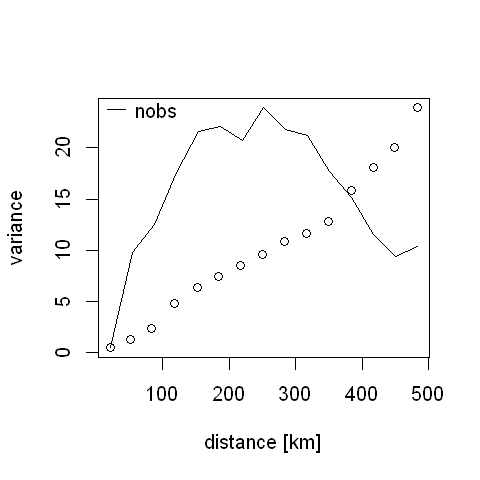

In [6]:
dsp <- d                                                           #copy data to make spatial data frame
coordinates(dsp) <- ~ lon + lat                                    #define coordinates; changes dsp to class spatial data frame
proj4string(dsp)=CRS("+proj=longlat +datum=WGS84")                 #project latitude/longitude according to equal area

d_evg <- variogram(temp_jan ~ 1, dsp, cutoff=500)                  #estimate empirical variogram
plot(d_evg$dist, d_evg$gamma,xlab='distance [km]',ylab='variance') #plot the empirical variogram
par(new=TRUE)                                                      #overplot
plot(d_evg$np,xaxt='n',yaxt='n',xlab='',ylab='',type='l')          #plot the number of observations used to compute empirical variances
legend('topleft',bty='n',lwd=1,legend='nobs')                      #label the line

Now our job is to fit a functional form to this empirical scatterplot. In R package ``gstat``, the function ``fit.variogram`` will do this for us, with some fancy backend magic regarding how to treat the unequal number of observations. The function takes the initial values for the variogram parameters as inputs, which tells the function which parameteres to include in the model. Additional arguements can be used to tell the package which parameters to keep fixed. We eyeball and fix the range as it appears to considerably help convergence for this particular dataset. Then we plot the empirical and optimized variogram simultaneously.

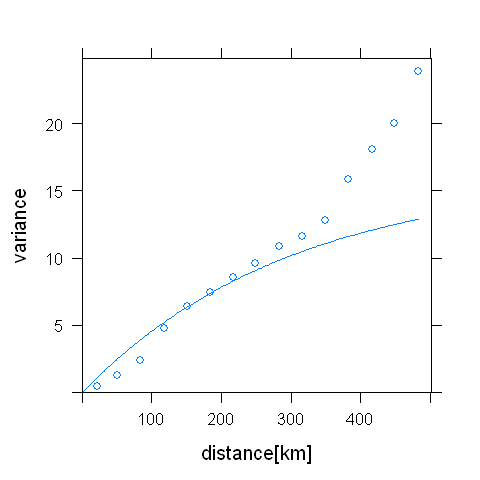

In [7]:
d_vg = fit.variogram(d_evg, model=vgm(psill=20,                       #initial sill value for optimizer
                                      model="Exp",                    #functional form
                                      range=300,                      #initial range value
                                      nugget=0.2*mean(dsp$temp_jan)), #initial nuggest value
                                      fit.ranges=FALSE)               #tell the package not to optimize range (helps with convergence)
plot(d_evg,d_vg,ylab='variance',xlab='distance[km]')                  #plot the empirical and optimized variogram together

As pointed out above, the goal of Krigeing is often to interpolate values at unobserved locations. Given the optimized variogram, we can now construct our necessary function $\gamma(d)$ for the observations and new point to predict from. Similarly, we can construct the variance of those predictions.  

[using ordinary kriging]


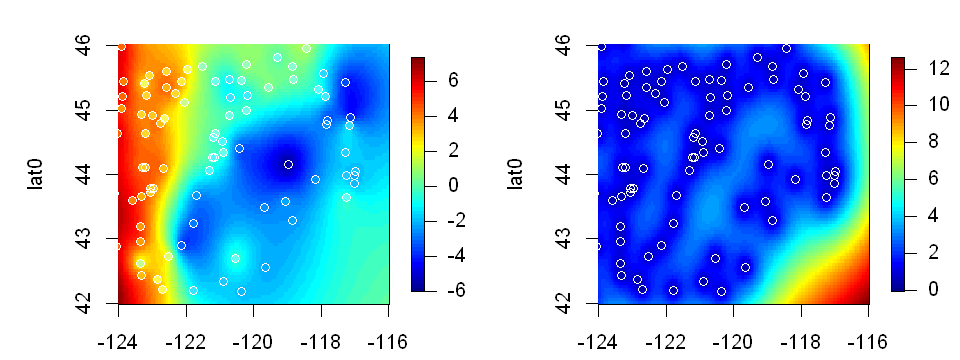

In [8]:
latr <- as.integer(range(dsp$lat))                                         #obserbed latitude range
lonr <- as.integer(range(dsp$lon))                                         #observed longitude range

res  <- 0.05                                                               #resolution of input lat/lon grid [degrees]
lat0 <- seq(from=latr[1], to=latr[2], by=res)                              #input latitudes
lon0 <- seq(from=lonr[1], to=lonr[2], by=res)                              #input longitudes
grd <- expand.grid(lon=lon0,lat=lat0)                                      #input grid
coordinates(grd) <- ~ lon + lat                                            #define coordiantes; makes grd a spatial data frame
proj4string(grd)=CRS("+proj=longlat +datum=WGS84")                         #project lat/lon with equal area
gridded(grd) <- TRUE                                                       #change attribute

d_k = krige(formula=temp_jan ~ 1, locations=dsp, newdata=grd, model=d_vg)  #krigeing prediction; temp_jan ~ 1 specifies the mean, locations defines observation points, newdata represents prediction points
dkdf <- as.data.frame(d_k)                                                 #change back to regular data frame  

options(repr.plot.width=8, repr.plot.height=3)               
par(mfrow=c(1,2))
image.plot(lon0,lat0,xtabs(dkdf[,3] ~ dkdf[,1] + dkdf[,2]))                #display the matrix; xtabs fills in the matrix elements with row and column dimensions
cols <- matlab.like(100)[as.numeric(cut(d$temp_jan,breaks=100))]           #attach color to matrix values
points(d$lon,d$lat,col=cols,pch=19)                                        #overplot the points with colors for observed values
points(d$lon,d$lat,col='white')                                            #give them a white outline to make them show up

image.plot(lon0,lat0,xtabs(dkdf[,4] ~ dkdf[,1] + dkdf[,2]))                #plot the krigeing variance
points(d$lon,d$lat,col='white')                                            #plot locations as white outline

## Spatial regression
Again following from the time series regression, we can investigate the relation among two variables while accounting for spatial autocorrelation. The linear regression we will fit is written as 

$$ y_i = \beta_0 + \beta_1 x1_i + \beta_2 x2_i + ,..., + \beta_n xn_i + e_i  $$

where $e_i$ is a Gaussian variable with spatial covariance $\mathbf{\Sigma}$

We take a look at the first few rows of the data to remind us of the variables

In [9]:
d[1:3,]      #display the top three rows of the dataset

station,lat,lon,elevation,temp_jan,temp_jul,temp_annual,precip_jan,precip_jul,precip_ann,county
ANT,44.917,-120.717,846,0.0,20.2,9.6,41,9,322,ANTELOPE 1 N USA-OR
ARL,45.717,-120.200,96,0.9,24.6,12.5,40,6,228,ARLINGTON USA-OR
ASH,42.217,-122.717,543,3.1,20.8,11.1,70,7,480,ASHLAND 1 N USA-OR


Below we fit the regression model with a single covariate and an exponential covariance matrix

In [10]:
fit <- gls(precip_ann ~ temp_annual, data=d, correlation=corExp(form=~lat+lon,nugget=FALSE),method='ML')  #fit linear regression model while account for spatial autocorrelation 
summary(fit)    #print a summary of the fitted model object

Generalized least squares fit by maximum likelihood
  Model: precip_ann ~ temp_annual 
  Data: d 
       AIC      BIC    logLik
  1297.666 1307.753 -644.8329

Correlation Structure: Exponential spatial correlation
 Formula: ~lat + lon 
 Parameter estimate(s):
   range 
6.072546 

Coefficients:
                Value Std.Error   t-value p-value
(Intercept) 1825.4297  711.1956  2.566706  0.0119
temp_annual  -71.6271   20.8419 -3.436694  0.0009

 Correlation: 
            (Intr)
temp_annual -0.303

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.2982015 -0.9274755 -0.6598595  0.3166358  1.5576293 

Residual standard error: 917.6314 
Degrees of freedom: 92 total; 90 residual

In [11]:
fit2 <- gls(precip_ann ~ temp_annual + elevation, data=d, correlation=corExp(form=~lat+lon,nugget=FALSE),method='ML')
summary(fit2)

Generalized least squares fit by maximum likelihood
  Model: precip_ann ~ temp_annual + elevation 
  Data: d 
       AIC      BIC    logLik
  1299.665 1312.273 -644.8323

Correlation Structure: Exponential spatial correlation
 Formula: ~lat + lon 
 Parameter estimate(s):
  range 
6.00687 

Coefficients:
                Value Std.Error   t-value p-value
(Intercept) 1839.7755  834.5722  2.204453  0.0301
temp_annual  -72.8775   40.1626 -1.814559  0.0730
elevation     -0.0087    0.2362 -0.036931  0.9706

 Correlation: 
            (Intr) tmp_nn
temp_annual -0.584       
elevation   -0.526  0.853

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.3011053 -0.9242965 -0.6596994  0.3196872  1.5646255 

Residual standard error: 912.847 
Degrees of freedom: 92 total; 89 residual

Just like we fitted a variogram to observed data, we can also fit a variogram model to model predictions. Below we take the predictions from the linear regression model and estimate their predicted empirical variogram. 

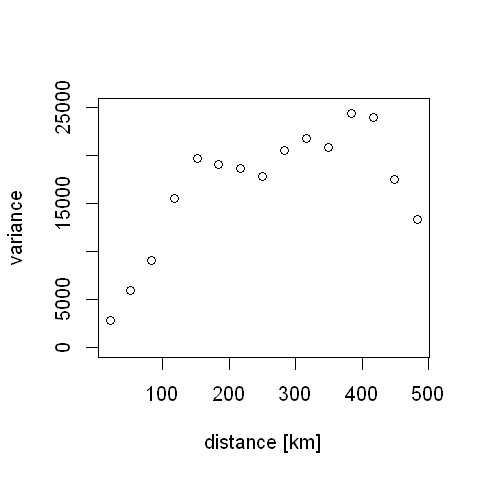

In [14]:
dsp$pred <- predict(fit2)
pred_evg <- variogram(pred ~ 1, dsp, cutoff=500)
options(repr.plot.width=4, repr.plot.height=4)  
par(mfrow=c(1,1))
plot(pred_evg$dist, pred_evg$gamma,xlab='distance [km]',ylab='variance',ylim=c(0,25000))

[using ordinary kriging]


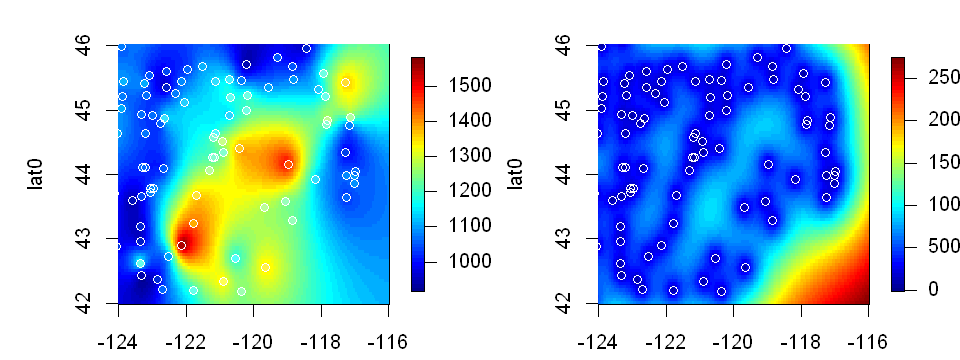

In [17]:
latr <- as.integer(range(dsp$lat))
lonr <- as.integer(range(dsp$lon))

res  <- 0.05
lat0 <- seq(from=latr[1], to=latr[2], by=res)
lon0 <- seq(from=lonr[1], to=lonr[2], by=res)
grd <- expand.grid(lon=lon0,lat=lat0)
coordinates(grd) <- ~ lon + lat
proj4string(grd)=CRS("+proj=longlat +datum=WGS84")
gridded(grd) <- TRUE

pred_vg = fit.variogram(pred_evg, model=vgm(psill=20,model="Exp",range=200,nugget=0.2*mean(dsp$temp_jan)), fit.ranges=FALSE)

pred_k  <- krige(formula=pred ~ 1, locations=dsp, newdata=grd, model=pred_vg)
predkdf <- as.data.frame(pred_k)

options(repr.plot.width=8, repr.plot.height=3)  
par(mfrow=c(1,2))
image.plot(lon0,lat0,xtabs(predkdf[,3] ~ predkdf[,1] + predkdf[,2]))
cols <- matlab.like(100)[as.numeric(cut(dsp$pred,breaks=100))]
points(dsp$lon,dsp$lat,col=cols,pch=19)
points(dsp$lon,dsp$lat,col='white')

image.plot(lon0,lat0,xtabs(predkdf[,4] ~ predkdf[,1] + predkdf[,2]))
points(dsp$lon,dsp$lat,col='white')

## Alternative autocorrelation functions
So far we have considered two closely related autocorrelation functions, the *first order autoregressive* covariance for time series, and the *exponential* autocovariance for spatial data. There is actually many functional forms we could use. Again casting the autocorrelation function in terms of the variogram, we can take a look at the available variograms in ``gstat`` by issueing the command  ``show.vgms()``

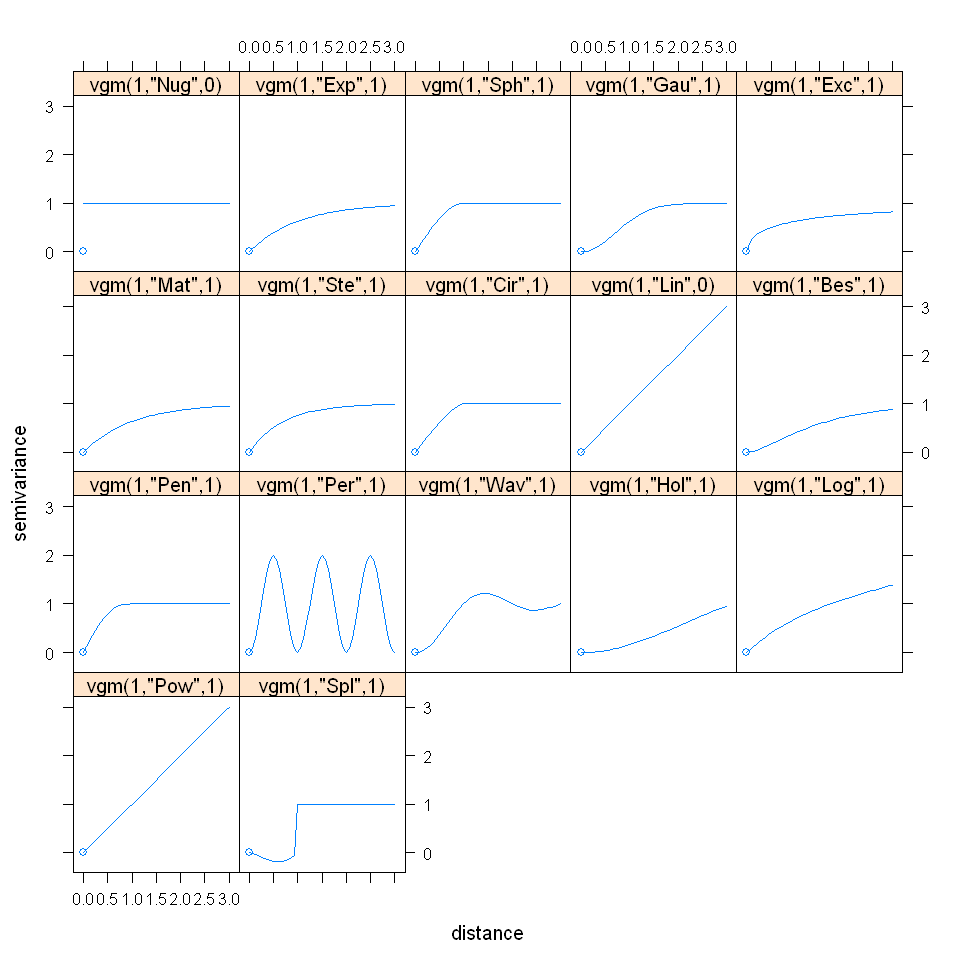

In [18]:
options(repr.plot.width=8, repr.plot.height=8)  
show.vgms(cex=0.5)

Below we optimize the parameters for two different functional forms and plot the results.

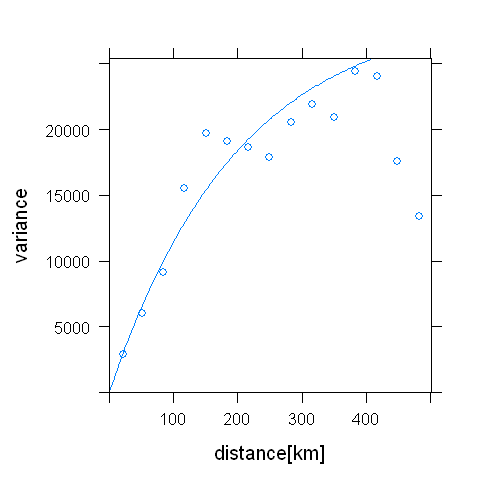

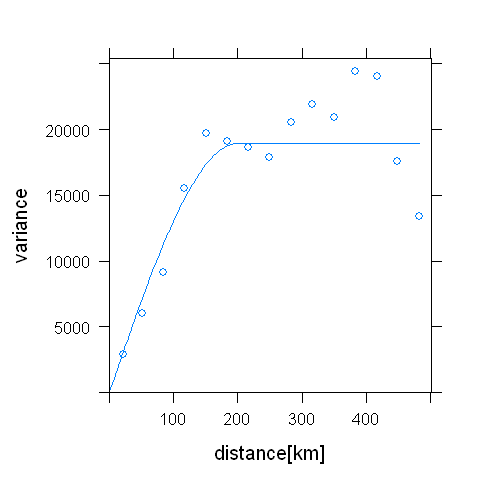

In [15]:
pred_vg1 = fit.variogram(pred_evg, model=vgm(psill=20,model="Exp",range=200,nugget=0.2*mean(dsp$temp_jan)), fit.ranges=FALSE)
pred_vg2 = fit.variogram(pred_evg, model=vgm(psill=20,model="Sph",range=200,nugget=0.2*mean(dsp$temp_jan)), fit.ranges=FALSE)

options(repr.plot.width=4, repr.plot.height=4)  

plot(pred_evg,pred_vg1,ylab='variance',xlab='distance[km]')
plot(pred_evg,pred_vg2,ylab='variance',xlab='distance[km]',add=TRUE)

As we learned in the time series section, we can also perform model selection with respect to spatial regression variables and also spatial varigorams. We again use the Bayesian information criterion (BIC) as a simple metric to balance the quality of the fit and the number of parameters used to fit the model

$$ \mathrm{BIC} = -2\log p(\mathbf{y} | \hat{\mathbf{\theta}},M,\hat{\sigma}^2) + k\log n $$

where $\log p(\mathbf{y} | \hat{\mathbf{\theta}},M,\hat{\sigma}^2)$ is the log likelihood for the observations evaluated at the optimal parameters, conditional on the model $M$, $k$ is the number of free parameters used to fit the model, and $n$ is the number of data points in the fit. 


## Model selection

In [32]:
fit1 <- gls(precip_ann ~ temp_annual,             data=d, correlation=corExp(form=~lat+lon,nugget=FALSE),method='ML')  #fit the regression with exponential covariance matrix
fit2 <- gls(precip_ann ~ elevation,               data=d, correlation=corExp(form=~lat+lon,nugget=FALSE),method='ML')
fit3 <- gls(precip_ann ~ temp_annual + elevation, data=d, correlation=corExp(form=~lat+lon,nugget=FALSE),method='ML')
BIC(fit1,fit2,fit3)  #display the Bayesian Information Criterion of the fits   

,df,BIC
fit1,4,1307.753
fit2,4,1310.968
fit3,5,1312.273


[1] -644.8329

[1] -646.4403

[1] -644.8323

In [20]:
fit1spher  <- gls(precip_ann ~ temp_annual, data=d, correlation=corSpher(form=~lat+lon,nugget=FALSE),method='ML')  #fit the regression with exponential covariance matrix
fit1exp    <- gls(precip_ann ~ temp_annual, data=d, correlation=corExp(form=~lat+lon,nugget=FALSE),method='ML')
BIC(fit1spher,fit1exp)   #display the Bayesian information crtierion of the fits

,df,BIC
fit1spher,4,1306.940
fit1exp,4,1307.753
